In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
import kagglehub

path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

100%|██████████| 736M/736M [00:34<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


In [3]:
data_dir='/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    filpath=os.path.join(data_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series,l_series],axis=1)

In [4]:
df

,filepath,labels
0,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
1,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
2,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
3,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
4,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
...,...,...
4212,/root/.cache/kagglehub/datasets/gunavenkatdodd...,glaucoma
4213,/root/.cache/kagglehub/datasets/gunavenkatdodd...,glaucoma
4214,/root/.cache/kagglehub/datasets/gunavenkatdodd...,glaucoma
4215,/root/.cache/kagglehub/datasets/gunavenkatdodd...,glaucoma


In [5]:
strat=df['labels']
train_df,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [6]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(2951, 2)
(633, 2)
(633, 2)


In [7]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['label','count']
fig=px.bar(count_train,x='label',y='count',title='count of train_df',text_auto=True)
fig.show()

In [8]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['label','count']
fig=px.bar(count_test,x='label',y='count',title='count of test_df',text_auto=True)
fig.show()

In [9]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['label','count']
fig=px.bar(count_valid,x='label',y='count',title='count of valid_df',text_auto=True)
fig.show()

In [10]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


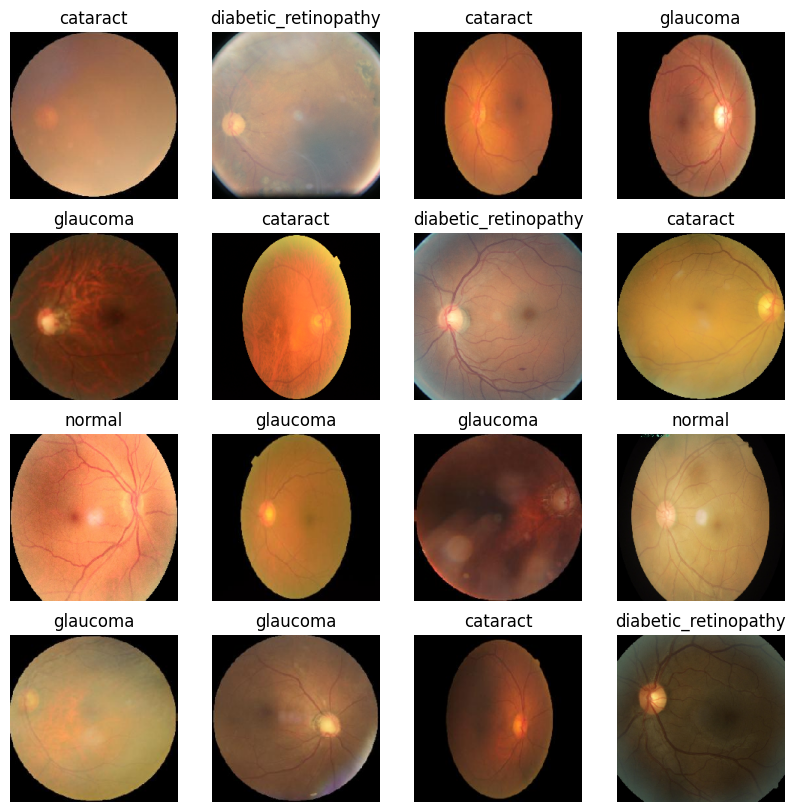

In [11]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

In [12]:
base_model=keras.applications.EfficientNetB3(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(4,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7259 - loss: 1.1812 - val_accuracy: 0.7630 - val_loss: 0.7494
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9377 - loss: 0.1800 - val_accuracy: 0.8784 - val_loss: 0.4322
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 433ms/step - accuracy: 0.9616 - loss: 0.0927 - val_accuracy: 0.8673 - val_loss: 0.4952
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 370ms/step - accuracy: 0.9731 - loss: 0.0748 - val_accuracy: 0.9194 - val_loss: 0.2663
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.9842 - loss: 0.0447 - val_accuracy: 0.9210 - val_loss: 0.3036
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 364ms/step - accuracy: 0.9913 - loss: 0.0208 - val_accuracy: 0.9179 - val_loss: 0.3065
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.9835 - loss: 0.0405 - val_accuracy: 0.9068 - val_loss: 0.3823
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.9848 - loss: 0.0370 - va

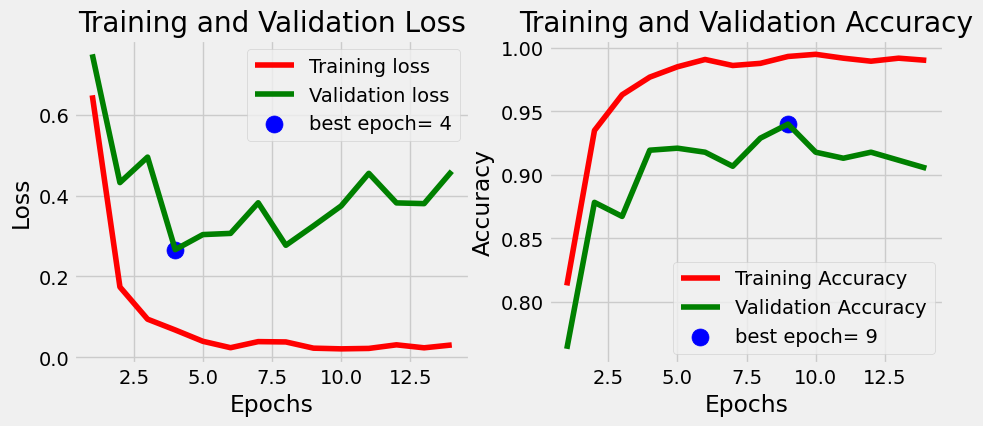

In [15]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

211/211 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step - accuracy: 0.9941 - loss: 0.0166
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9184 - loss: 0.2671  
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9064 - loss: 0.3474  
Train Loss:  0.01600145362317562
Train Accuracy:  0.9942392706871033
--------------------
Valid Loss:  0.2663385570049286
Valid Accuracy:  0.9194312691688538
--------------------
Test Loss:  0.3485051095485687
Test Accuracy:  0.9067930579185486


In [17]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 751ms/step


In [18]:
print(y_pred)

[3 1 0 3 3 1 0 2 3 2 1 2 2 1 0 1 2 3 1 0 1 2 0 0 0 3 2 1 2 0 3 3 2 3 1 1 3
 3 1 0 2 1 3 0 1 2 1 3 3 2 3 2 0 0 2 3 1 2 1 3 2 1 2 1 3 1 2 1 0 1 2 0 1 0
 3 1 1 1 0 1 0 1 1 0 3 0 3 1 2 2 2 2 1 0 1 2 1 0 0 0 2 0 1 1 3 1 3 3 1 0 0
 2 1 3 3 3 3 3 3 0 1 3 3 0 2 3 1 0 0 3 3 3 1 1 0 0 0 0 1 1 0 2 0 1 3 2 3 2
 3 3 3 1 3 3 1 2 0 1 0 1 0 3 1 2 3 2 3 0 0 0 3 0 2 1 2 3 1 3 2 3 0 0 2 0 2
 3 2 3 1 3 0 1 3 1 3 3 2 3 2 3 1 1 2 3 2 3 0 2 0 0 0 0 1 2 3 2 0 1 1 1 3 3
 2 2 2 1 0 1 3 3 2 0 3 1 0 2 0 0 3 1 0 2 1 3 3 1 3 2 0 2 1 2 3 2 0 3 0 2 3
 1 3 3 0 1 2 3 2 0 1 0 2 1 2 2 1 1 1 2 0 1 3 3 0 2 0 1 0 1 3 2 1 1 1 2 2 0
 0 3 1 0 2 3 0 3 3 0 2 2 3 2 3 3 2 2 3 3 0 1 2 1 2 2 2 1 3 3 1 0 2 0 3 1 1
 1 2 3 2 0 0 1 2 1 1 0 2 0 2 1 1 2 0 2 1 3 3 3 3 2 3 1 1 2 3 2 0 3 2 3 3 2
 1 1 1 0 0 0 0 1 3 2 3 0 3 3 1 2 2 3 2 3 1 0 3 1 1 3 0 3 0 0 0 3 2 3 0 1 0
 0 1 0 3 2 3 3 0 0 2 3 1 3 0 2 3 3 0 0 2 1 2 1 2 1 2 2 0 0 1 2 1 1 2 3 3 3
 0 0 2 1 2 2 0 0 0 2 0 0 1 2 0 0 0 3 3 1 1 2 0 2 3 3 3 1 1 2 0 1 3 3 0 1 1
 1 2 0 3 3 3 3 2 0 3 3 2 

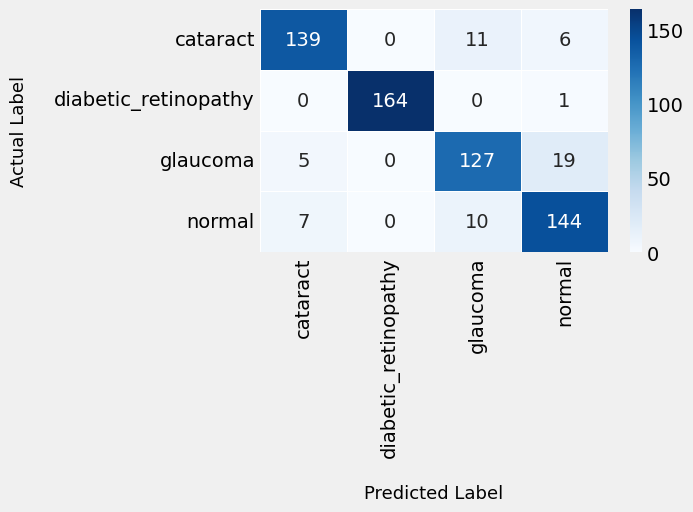

In [21]:
plt.figure(figsize=(5,3))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [22]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

            cataract       0.92      0.89      0.91       156
diabetic_retinopathy       1.00      0.99      1.00       165
            glaucoma       0.86      0.84      0.85       151
              normal       0.85      0.89      0.87       161

            accuracy                           0.91       633
           macro avg       0.91      0.91      0.91       633
        weighted avg       0.91      0.91      0.91       633

